<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Char_RNN_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP with RNNs

Can we build a machine that can read and write natural language?

A common approach for natural language tasks is to use recurrent neural networks. We will continue to explore RNNs (introduced in previous notebooks [Introduction to RNNs](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_RNNs.ipynb), [RNNs for long sequences](https://github.com/victorviro/Deep_learning_python/blob/master/RNNs_long_sequences.ipynb)), with a Character-Level Language Model which we call *character RNN*, trained to predict the next character in a sentence. This will allow us to generate some original text, and in the process, we will see how to build a TensorFlow Dataset on a very long sequence. We will first use a *stateless RNN* (which learns on random portions of text at each iteration, without any information on the rest of the text), then we will build a stateful RNN (which preserves the hidden state between training iterations and continues reading where it left off, allowing it to learn longer patterns). 



# Lenguage model

Given any sentence or sequence of words/characters $w_1,w_2, …,w_T$, a language model tries to predict what is the probability of that sentence. In other words, the language model tries to learn the joint probability distribution of sequences of characters/words in a training text, i.e. trying to learn the joint probability function. For example, if we are trying to predict a sequence of $T$ words, we try to get the joint probability $P(w_1,w_2,...,w_T)$
 as big as we can. Applying the [general product rule](https://en.wikipedia.org/wiki/Chain_rule_(probability)) we can express this joint probability in terms of conditional probabilities $P(w_1,w_2,...,w_T)=\prod_{t=1}^{T}P(w_t|w_{t-1},...,w_1)$. 

For a further explanation of how language models work, check this [video](https://www.coursera.org/lecture/nlp-sequence-models/language-model-and-sequence-generation-gw1Xw).




## Character RNN

The term "char-rnn" is short for "character recurrent neural network", and is effectively a recurrent neural network trained to predict the next character given a sequence of previous characters. In this way, we can think of a char-rnn as a classification model. In the same way that we output a probability distribution over classes when doing image classification, for a char-rnn we wish to output a probability distribution over character classes, i.e., a vocabulary of characters. Unlike image classification where we are given a single image and expected to predict an output immediately, however, in this setting, we are given the characters one at a time and only expected to predict an output after the last character.


In a famous 2015 [blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) titled "The Unreasonable Effectiveness of Recurrent Neural Networks", Andrej Karpathy showed how to train an RNN to predict the next character in a sentence. This *Char-RNN* can then be used to generate novel text, one character at a time.

Let’s look at how to build a Char-RNN, step by step, starting with the creation of the dataset.

### Creating the training dataset

First, let’s download all of Shakespeare’s work, using Keras’s handy `get_file()` function and downloading the data from Andrej Karpathy’s [Char-RNN project](https://github.com/karpathy/char-rnn):

In [ ]:
import numpy as np
import tensorflow as tf
import keras

In [ ]:
shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
print(f'Lenght of text: {len(shakespeare_text)} characters')
print(f'First 100 characters of the text:\n{shakespeare_text[:250]}')

Lenght of text: 1115394 characters
First 100 characters of the text:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



Next, we must encode every character as an integer. We use Keras’s [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer?hl=en) class. First, we need to fit a tokenizer to the text: it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters (it does not start at 0, so we can use that value for masking):

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)


We set `char_level=True` to get character-level encoding rather than the default word-level encoding. Note that this tokenizer converts the text to lowercase by default (but we can set `lower=False` if we do not want that). Now the tokenizer can encode a sentence (or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text:

In [ ]:
print(f'Sentence "{shakespeare_text[:5]}" encoded as {tokenizer.texts_to_sequences([shakespeare_text[:5]])}')
print(f'[[20, 6, 9, 8, 3]] -----> {tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])}')

vocab_size = len(tokenizer.word_index) #max_id
print(f'Number of distinct characters in text: {vocab_size}')

dataset_size = tokenizer.document_count 
print(f'Total number of characters in text: {dataset_size}')

Sentence "First" encoded as [[20, 6, 9, 8, 3]]
[[20, 6, 9, 8, 3]] -----> ['f i r s t']
Number of distinct characters in text: 39
Total number of characters in text: 1115394


Let’s encode the full text so each character is represented by its ID (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39):

In [ ]:
[text_as_int] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
print(f'Full text encoded: {text_as_int}')
print(f'Total number of characters in text: {len(text_as_int)}')

Full text encoded: [19  5  8 ... 20 26 10]
Total number of characters in text: 1115394


Let’s create a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) that will return each character one by one from this set:

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
for element in dataset.take(5):
    print(element)

tf.Tensor(19, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [ ]:
print(dataset.cardinality().numpy())

1115394


### Chopping the Sequential Dataset into Multiple Windows

The training set now consists of a single sequence of over a million characters, so we can’t just train the neural network directly on it: the RNN would be equivalent to a deep net with over a million layers, and we would have a single (very long) instance to train it. Instead, we will convert this long sequence of characters into many smaller windows or subsequences of text. Every instance in the dataset will be a fairly short substring of the whole text, and the RNN will be unrolled only over the length of these substrings. This is called *truncated backpropagation through time* (see notebook [Introduction to RNNs](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_RNNs.ipynb)). Let’s call the `batch()` method to create a dataset of short text windows:

In [ ]:
n_steps = 100
window_length = n_steps+1
windows = dataset.batch(window_length, drop_remainder=True)

In [ ]:
for window_tensor in windows.take(2):
    print(window_tensor)

tf.Tensor(
[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24
 17  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23
 10 15  3 13  0], shape=(101,), dtype=int64)
tf.Tensor(
[ 4  8  1  0  4 11 11  0  8  1  7  3 11 25  1 12  0  8  4  2  6  1  8  0
  2  3  0 12  5  1  0  2  6  4  9  0  2  3  0 19  4 14  5  7  6 29 10 10
  4 11 11 23 10  8  1  7  3 11 25  1 12 26  0  8  1  7  3 11 25  1 12 26
 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 19  5  8  7  2 17  0
 15  3 13  0 24], shape=(101,), dtype=int64)


**Note**: We can try tuning `window_length`: it is easier to train RNNs on shorter input sequences, but of course the RNN will not be able to learn any pattern longer than `window_length`, so we don’t make it too small.

By default, the `batch()` method creates nonoverlapping windows. To ensure that all windows are exactly 101 characters long (which will allow us to create batches without having to do any padding), we set `drop_remainder=True` (otherwise the last window can contain less than 101 characters). Notice that we call `batch(window_length)` so all windows have exactly that length and we will get a single tensor for each of them. Now the dataset contains consecutive windows of 101 characters each.



We create a function to separate the inputs (the first 100 characters) from the target (the last 100 characters):

In [ ]:
def split_input_target(windows):
  input_text = windows[:-1]
  target_text = windows[1:]
  return input_text, target_text

dataset = windows.map(split_input_target)

In [ ]:
for input_example, target_example in  dataset.take(1):
  print(input_example)
  print(target_example)

tf.Tensor(
[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24
 17  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23
 10 15  3 13], shape=(100,), dtype=int64)
tf.Tensor(
[ 5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1  0
 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1  4
  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24 17
  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23 10
 15  3 13  0], shape=(100,), dtype=int64)


### Create training batches

Since Gradient Descent works best when the instances in the training set are independent and identically distributed, we need to shuffle these windows.

In [ ]:
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
for batch in dataset.take(1):
    print(batch)

(<tf.Tensor: shape=(32, 100), dtype=int64, numpy=
array([[14,  3,  7, ...,  4,  5,  9],
       [ 9, 20,  0, ...,  1,  7,  0],
       [ 3,  8,  0, ..., 18, 15,  0],
       ...,
       [ 2,  6,  4, ...,  9, 20, 27],
       [ 7,  2,  3, ...,  1,  4,  8],
       [ 9,  7, 28, ..., 14,  3,  8]])>, <tf.Tensor: shape=(32, 100), dtype=int64, numpy=
array([[ 3,  7,  2, ...,  5,  9,  0],
       [20,  0,  2, ...,  7,  0,  2],
       [ 8,  0,  5, ..., 15,  0, 21],
       ...,
       [ 6,  4,  2, ..., 20, 27,  7],
       [ 2,  3,  8, ...,  4,  8,  7],
       [ 7, 28,  0, ...,  3,  8,  1]])>)


In [ ]:
dataset

<BatchDataset shapes: ((32, 100), (32, 100)), types: (tf.int64, tf.int64)>

Categorical input features should generally be encoded, usually as one-hot vectors or as embeddings. We could encode each character using a one-hot vector because there are fairly few distinct characters (only 39), but we will encode them as embeddings when defining the model.

That’s it! Preparing the dataset was the hardest part. Now let’s create the model.



### Building and Training the Char-RNN Model

To predict the next character based on the previous 100 characters, we can use an RNN with 1 `GRU` layer of 1024 units each and 20% dropout on the inputs (`dropout`). We can tweak these hyperparameters later if needed. The output layer is a `Dense` layer which must have 39 units (`vocab_size`) because there are 39 distinct characters in the text, and we want to output a probability for each possible character (at each time step). We choose to Keras sequential model here since all the layers in the model only have a single input and produce a single output. 

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size, stateful):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=stateful,
                            dropout=0.2),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

Let's create the model.



In [ ]:
# Number of RNN units
rnn_units = 1024 

# The embedding dimension
embedding_dim = 256

model = build_model(vocab_size = vocab_size, embedding_dim=embedding_dim,
                    rnn_units=rnn_units, batch_size=BATCH_SIZE, stateful=False)

We set `stateful=False` because we are building a stateless model, that is the internal state of the `GRU` layer is reset every time it sees a new batch. This is useful when every sample is assumed to be independent of the past. Note that this is not our case since we have broken the whole text into shorter sequences (windows of length 101), although we are going to feed these shorter sequences shuffled into the RNN layer. It would be appropriate to build a stateful model and feed the windows sequentially onto the RNN layer as we will see it in the next section.

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![](https://i.ibb.co/fpn6qR1/stateless-char-rnn.png)



In our example the window length of the input is 101 but the model can be run on inputs of any length:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           9984      
_________________________________________________________________
gru (GRU)                    (32, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (32, None, 39)            39975     
Total params: 3,988,263
Trainable params: 3,988,263
Non-trainable params: 0
_________________________________________________________________


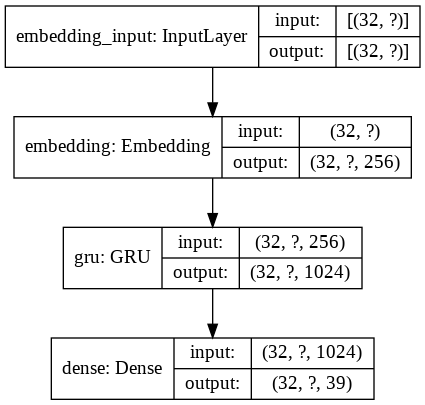

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

Before training the model, we run the model to see that it behaves as expected. First, we check the shape of the output:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
   example_batch_predictions = model(input_example_batch)
   print(example_batch_predictions.shape, "# (batch_size, window_length, vocab_size)")

(32, 100, 39) # (batch_size, window_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary. 

**Note**: It is important to sample from this distribution as taking the argmax of the distribution can easily get the model stuck in a loop as we will see when we generate fake Shakespearean text.

Let's try it for the first example in the batch:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([22,  5, 18, 34,  6, 24, 27, 33, 33, 27, 38, 12, 26,  4, 30, 18,  1,
       31, 32, 26, 30, 27, 19,  0, 18, 16, 12, 30, 11, 22, 29, 24, 22, 28,
       29, 26, 10, 30,  1,  8, 11, 33,  6,  0, 11, 19, 30, 19, 24, 23,  8,
       33,  5, 29, 16, 28, 20,  7, 10, 10, 22, 11,  4, 12, 20, 32, 19, 30,
       11, 25, 38, 27, 13, 10, 35, 22, 24,  2, 18, 14, 33, 18, 38, 18, 22,
       14, 17, 32, 22, 37,  0, 11, 16, 32, 34, 20, 26,  9,  3, 10])

This gives us, at each timestep, a prediction of the next character index.

As we said, the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character. The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions. Because our model returns logits (we did not use the activation function in the last `Dense` layer), we need to set the `from_logits` flag.

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

Let's compute the loss for the first example in the batch:

In [ ]:
example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, window_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 39)  # (batch_size, window_length, vocab_size)
scalar_loss:       3.663464


We can then compile this model, using the loss previously defined and an Adam optimizer. Finally, we are ready to train the model for several epochs (this may take many hours, depending on our hardware):

In [ ]:
model.compile(loss=loss, optimizer="adam")


In [ ]:
print(f'Number of batches in the dataset: {dataset_size // window_length // BATCH_SIZE}')

Number of batches in the dataset: 345


In [ ]:
history = model.fit(dataset, epochs=30)

Epoch 1/30
345/345 [==============================] - 12s 34ms/step - loss: 2.3382
Epoch 2/30
345/345 [==============================] - 12s 34ms/step - loss: 1.7076
Epoch 3/30
345/345 [==============================] - 12s 34ms/step - loss: 1.4986
Epoch 4/30
345/345 [==============================] - 12s 34ms/step - loss: 1.3980
Epoch 5/30
345/345 [==============================] - 12s 34ms/step - loss: 1.3321
Epoch 6/30
345/345 [==============================] - 12s 34ms/step - loss: 1.2789
Epoch 7/30
345/345 [==============================] - 12s 35ms/step - loss: 1.2311
Epoch 8/30
345/345 [==============================] - 12s 35ms/step - loss: 1.1850
Epoch 9/30
345/345 [==============================] - 12s 35ms/step - loss: 1.1394
Epoch 10/30
345/345 [==============================] - 12s 35ms/step - loss: 1.0930
Epoch 11/30
345/345 [==============================] - 12s 35ms/step - loss: 1.0465
Epoch 12/30
345/345 [==============================] - 12s 35ms/step - loss: 1.0018
E

### Using the Char-RNN Model

Now we have a model that can predict the next character in the text written by Shakespeare. After this model is trained, it will only be possible to use it to make predictions for batches of the same size as were used during training. To avoid this restriction, we create an identical model but using batch size 1, and copy the model’s weights to this model.

In [ ]:
weigths_model = model.get_weights()

model_pred = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1, stateful=False)

model_pred.set_weights(model.get_weights())

model= model_pred


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            9984      
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 39)             39975     
Total params: 3,988,263
Trainable params: 3,988,263
Non-trainable params: 0
_________________________________________________________________


To feed it some text to the model, we first need to preprocess it like we did earlier, so let’s create a little function for this.


In [ ]:
def encode_text_to_integers(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return X

In [ ]:
X_new = encode_text_to_integers(["How are yo"])
print(f'Input text vectorized: {X_new}')

Input text vectorized: [[ 6  3 16  0  4  8  1  0 15  3]]


Now let’s use the model to predict the next letter in some text:

In [ ]:
Y_pred = np.argmax(model.predict(X_new), axis=-1)
print(tokenizer.sequences_to_texts(Y_pred + 1)[0][-1])

u


The model guessed right. Now let’s use this model to generate new text.

### Generating Fake Shakespearean Text

To generate new text using the Char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter, and so on. But in practice, this often leads to the same words being repeated over and over again. Instead, we can pick the next character randomly, with a probability equal to the estimated probability, using TensorFlow’s `tf.random.categorical()` function. This will generate a more diverse and interesting text. The `categorical()` function samples random class indices, given the class log probabilities (logits). To have more control over the diversity of the generated text, we can divide the logits by a number called the *temperature*, which we can tweak as we wish: a *temperature* close to 0 will favor the high-probability characters, while a very high temperature will give all characters an equal probability. The following `next_char()` function uses this approach to pick the next character to add to the input text:


In [ ]:
def next_char(start_string, temperature=1):
    # Converting our start string to numbers (vectorizing)
    X_new = encode_text_to_integers([start_string])
    predictions = model.predict(X_new)
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # using a categorical distribution to predict the character returned by the model
    temperature = 1.0
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    # Converting our vector prediction to string
    return tokenizer.sequences_to_texts([[predicted_id + 1]])[0]
    

In [ ]:
print(next_char("How are yo", temperature=1))

u


Next, we can write a small function that will repeatedly call `next_char()` to get the next character and append it to the given text:

In [ ]:
def complete_text(text, n_chars=200, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

The next figure depicts the procedure for generating text.

![](https://i.ibb.co/jJv8B2N/char-RNN-genberating-text.png)

We are now ready to generate some text! Let’s try with different temperatures:



In [ ]:
print(complete_text("ROMEO: ", temperature=0.2))

ROMEO: no man she does.

gloucester:
carth gonzalm, go but a higher banished;
for 'tis crack'd in a dishest person:
there was wait yours.ly, old grain,
never come now death is doubt.

second citizen:
once; f


In [ ]:
print(complete_text("ROMEO: ", temperature=1))

ROMEO: gentlemen, with the profition
let them heep: 'tis love it will.
i make you kindly.

marcius:
gentle sir, most high-behembed,
shall in the other. therefore, not well:
regetter you, my sovereign kings, 


Note that the model is character-based, so when training started, the model did not know how to spell an English word, or that words were even a unit of text.

Apparently, our Shakespeare model works best at a temperature close to 1. To generate more convincing text, we could try using more GRU layers, train for longer, and add some regularization (for example, we could set `recurrent_dropout=0.3` in the `GRU` layers). Moreover, the model is currently incapable of learning patterns longer than `n_steps`, which is just 100 characters. We could try making this window larger, but it will also make training harder, and even LSTM and GRU cells cannot handle very long sequences. Alternatively, we could use a stateful RNN.

### Stateful RNN

Until now, we have used only stateless RNNs: at each training iteration the model starts with a hidden state full of zeros, then it updates this state at each time step, and after the last time step, it throws it away, as it is not needed anymore. What if we told the RNN to preserve this final state after processing one training batch and use it as the initial state for the next training batch? This way the model can learn long-term patterns despite only backpropagating through short sequences. This is called a *stateful RNN*. Let’s see how to build one.

First, note that a stateful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off. So the first thing we need to do to build a stateful RNN is to use sequential and nonoverlapping input sequences. We will use the dataset’s `window()` method to convert this long sequence of characters into many smaller windows of text. We set the parameter `shift=n_steps` when calling the `window()` method. Note that the `window()` method creates a dataset that contains windows, each of which is also represented as a dataset. It’s a *nested dataset*, analogous to a list of lists. This is useful when we want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets. So, we must call the `flat_map()` method which converts a nested dataset into a flat dataset (one that does not contain datasets). 

Moreover, we must obviously not call the `shuffle()` method. Unfortunately, batching is much harder when preparing a dataset for a stateful RNN than it is for a stateless RNN. Indeed, if we were to call `batch(32)`, then 32 consecutive windows would be put in the same batch, and the following batch would not continue each of these window where it left off. The first batch would contain windows 1 to 32 and the second batch would contain windows 33 to 64, so if you consider, say, the first window of each batch (i.e., windows 1 and 33), you can see that they are not consecutive. The simplest solution to this problem is to just use “batches” containing a single window.

Figure 16-2 summarizes the dataset preparation steps discussed so far (showing windows of length 11 rather than 101, and a batch size of 1).

![texto alternativo](https://i.ibb.co/xSm5z3F/sequence-fragments-stateful-RNN.png)

Batching is harder, but it is not impossible. For example, we could chop Shakespeare’s text into 32 texts of equal length, create one dataset of consecutive input sequences for each of them, and finally use `tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))` to create proper consecutive batches, where the $n^{\text{th}}$ input sequence in a batch starts off exactly where the $n^{\text{th}}$ input sequence ended in the previous batch:

In [ ]:
batch_size = 32
encoded_parts = np.array_split(text_as_int, batch_size)#[:train_size]

In [ ]:
encoded_part = encoded_parts[0]
print(encoded_part.shape)
print(encoded_part)

(34857,)
[19  5  8 ...  7  0 19]


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
for element in dataset.take(5):
    print(element)
    

tf.Tensor(19, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [ ]:
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
for window in dataset.take(2):
    print(window)
    for element in window.take(2):
        print(element)

<_VariantDataset shapes: (), types: tf.int64>
tf.Tensor(19, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
<_VariantDataset shapes: (), types: tf.int64>
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))
for window_tensor in dataset.take(2):
    print(window_tensor)

tf.Tensor(
[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24
 17  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23
 10 15  3 13  0], shape=(101,), dtype=int64)
tf.Tensor(
[ 0  4  8  1  0  4 11 11  0  8  1  7  3 11 25  1 12  0  8  4  2  6  1  8
  0  2  3  0 12  5  1  0  2  6  4  9  0  2  3  0 19  4 14  5  7  6 29 10
 10  4 11 11 23 10  8  1  7  3 11 25  1 12 26  0  8  1  7  3 11 25  1 12
 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 19  5  8  7  2 17
  0 15  3 13  0], shape=(101,), dtype=int64)


In [ ]:
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Now let’s create the stateful RNN. First, we need to set `stateful=True` when creating every recurrent layer.


In [ ]:
model = build_model(vocab_size = vocab_size, embedding_dim=embedding_dim,
                    rnn_units=rnn_units, batch_size=32, stateful=True)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (32, None, 256)           9984      
_________________________________________________________________
gru_2 (GRU)                  (32, None, 1024)          3938304   
_________________________________________________________________
dense_2 (Dense)              (32, None, 39)            39975     
Total params: 3,988,263
Trainable params: 3,988,263
Non-trainable params: 0
_________________________________________________________________


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![](https://i.ibb.co/6ykYWq6/char-rnn.png)

At the end of each epoch, we need to reset the states before we go back to the beginning of the text. For this, we can use a small callback:

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

And now we can compile and fit the model:

In [ ]:
model.compile(loss=loss, optimizer="adam")

In [ ]:
print(f'Number of batches in the dataset: {dataset_size // batch_size // n_steps}')

Number of batches in the dataset: 348


In [ ]:
history = model.fit(dataset, epochs=30, callbacks=[ResetStatesCallback()])

Epoch 1/30
348/348 [==============================] - 14s 39ms/step - loss: 2.2843
Epoch 2/30
348/348 [==============================] - 14s 40ms/step - loss: 1.6461
Epoch 3/30
348/348 [==============================] - 14s 40ms/step - loss: 1.4416
Epoch 4/30
348/348 [==============================] - 14s 40ms/step - loss: 1.3428
Epoch 5/30
348/348 [==============================] - 14s 40ms/step - loss: 1.2757
Epoch 6/30
348/348 [==============================] - 14s 40ms/step - loss: 1.2202
Epoch 7/30
348/348 [==============================] - 14s 40ms/step - loss: 1.1700
Epoch 8/30
348/348 [==============================] - 14s 40ms/step - loss: 1.1196
Epoch 9/30
348/348 [==============================] - 14s 40ms/step - loss: 1.0696
Epoch 10/30
348/348 [==============================] - 14s 40ms/step - loss: 1.0225
Epoch 11/30
348/348 [==============================] - 14s 40ms/step - loss: 0.9819
Epoch 12/30
348/348 [==============================] - 14s 40ms/step - loss: 0.9509
E

As with the stateless model, after training, it will only be possible to use it to make predictions for batches of the same size as were used during training. To avoid this restriction, we create an identical model with batch_size 1, and copy the model’s weights to this model. To set the weights.



In [ ]:
weigths_model = model.get_weights()

model_pred = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1, stateful=False)

model_pred.set_weights(model.get_weights())

model= model_pred

In [ ]:
print(complete_text("ROMEO: ", temperature=1))

ROMEO: is thy
boneth he shall, my mounding successed?

friar laurence:
of so die in this cup blast send
from my order appetite, by this disguise,
fall not a wonder, i through my life
and tell him what your q


# References

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- https://github.com/ageron/handson-ml2

- [Text generation TensorFlow](https://www.tensorflow.org/tutorials/text/text_generation)

- [RNNs MIT lecture](https://www.youtube.com/watch?v=SEnXr6v2ifU)

- [Character-level Recurrent Neural Networks in Practice: Comparing Training and Sampling Schemes](https://arxiv.org/abs/1801.00632)

- [Keras examples: Character-level text generation with LSTM](https://keras.io/examples/generative/lstm_character_level_text_generation/)

- [Sequence Models course](https://www.coursera.org/lecture/nlp-sequence-models/language-model-and-sequence-generation-gw1Xw)

- [Character level language model](https://towardsdatascience.com/character-level-language-model-1439f5dd87fe)

